## А/В - тестирование.

**Цель:** Оценка результатов А/В - теста после внедрения улучшенной рекомендательной системы.
    
**Техническое задание:**

- название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: в тест должно быть отобрано 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.
    
**Описание данных:**

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 до 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время события;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

**План:**

*Шаг 1.* Первичная оценка данных, предобработка:

- оформление/стиль,
- типы данных,
- наличие пропусков, их природа?
- наличие/отсуствие дубликатов.

*Шаг 2.* Оценка корректности проведения теста: 

- соответствие данных требованиям технического задания,
- время проведения теста, убедимся что оно не совпадает с маркетинговыми и другими активностями,
- аудитория теста, убедимся, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверим равномерность распределения по тестовым группам и правильность их формирования.

*Шаг 3.* Исследовательский анализ данных:

- Количество событий на пользователя одинаково распределены в выборках?
- Как число событий в выборках распределено по дням?
- Как меняется конверсия в воронке в выборках на разных этапах?
- Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?

*Шаг 4.* Оценка результатов A/B-тестирования,проверка гипотез: 
    
- охарактеризуем результаты A/В-тестирования,
- проверим статистическую разницу долей z-критерием,
- проверим гипотезы.

*Шаг 5.* Общие выводы и заключение. 

- опишем выводы по этапу исследовательского анализа данных и по проведённой оценке результатов A/B-тестирования. Сделаем общее заключение о корректности проведения теста.

In [1]:
# выгрузим все необходимые библиотеки 
import pandas as pd
import numpy as np
import math as mth
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import graph_objects as go
import plotly.io as pio
pio.renderers.default = "png"
import scipy.stats as stats
import datetime as dt
from datetime import datetime, timedelta
pd.set_option('mode.chained_assignment', None)

In [2]:
try:
    events = pd.read_csv('final_ab_events.csv')
    users = pd.read_csv('final_ab_new_users.csv')
    participants = pd.read_csv('final_ab_participants.csv')
    project_marketing = pd.read_csv('ab_project_marketing_events .csv')
except:
    events = pd.read_csv('/datasets/final_ab_events.csv')
    users = pd.read_csv('/datasets/final_ab_new_users.csv')
    participants = pd.read_csv('/datasets/final_ab_participants.csv')
    project_marketing = pd.read_csv('/datasets/ab_project_marketing_events.csv')

#### Шаг 1. Первичная оценка данных, предобработка.

In [3]:
# создадим функцию, чтобы была возможность в один шаг увидеть всю общую информацию

def common_info(df):
    df.info() 
    print('\nПервые строки')
    display(df.head()),
    print('Распределение данных'),
    display(df.describe()),
    print('Пропуски'),
    display(df.isna().sum()),
    print('Дубликаты'),
    display(df.duplicated().sum())

In [4]:
common_info(events)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB

Первые строки


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


Распределение данных


,details
count,62740.000000
mean,23.877631
std,72.180465
min,4.990000
25%,4.990000
50%,4.990000
75%,9.990000
max,499.990000


Пропуски


user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

Дубликаты


0

In [5]:
# посмотрим на все возможные события, хранящиеся в event_name
display(events['event_name'].unique())

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

In [6]:
# посмотрим прицельно на поле details, где есть пропуски; какие им соответствуют события?
no_details = events[events['details'].isnull()]
no_details.groupby('event_name')['event_dt'].count()

event_name
login           189552
product_cart     62462
product_page    125563
Name: event_dt, dtype: int64

**Вывод:** 
- таблица содержит *440317* событий;
- 4 вида событий: авторизация, просмотр карточек товаров, просмотр корзины, покупка;
- event_dt имеет тип object, необходимо его преобразовать;
- полных дубликатов не найдено;
- пропуски есть в details(377577). Все пропуски в details соответствуют 3/4 событий - кроме покупки - *purchase*. Т.е. можно сделать вывод, что details могут быть заполнены только при покупке(содержит стоимость покупки в долларах). Поэтому, делаем вывод, что пропуски не случайны. Относим их к категории *MNAR* (Missing Not At Random / Отсутствует не случайно); отбрасывать/заполнять не будем.

In [7]:
# изменим тип данных в event_dt
events['event_dt'] = pd.to_datetime(events['event_dt'], format = '%Y-%m-%d %H:%M:%S')

# проверим изменения
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


In [8]:
common_info(users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB

Первые строки


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


Распределение данных


,user_id,first_date,region,device
count,61733,61733,61733,61733
unique,61733,17,4,4
top,D72A72121175D8BE,2020-12-21,EU,Android
freq,1,6290,46270,27520


Пропуски


user_id       0
first_date    0
region        0
device        0
dtype: int64

Дубликаты


0

In [9]:
# посмотрим на все регионы пользователей
display(users['region'].unique())

# посмотрим на все устройства, которые используются
users['device'].unique()

array(['EU', 'N.America', 'APAC', 'CIS'], dtype=object)

array(['PC', 'Android', 'iPhone', 'Mac'], dtype=object)

**Вывод:**

- таблица содержит данные *61733* пользователей;
- 4 региона: EU, N.America, APAC, CIS;
- 4 вида устройств: PC, Android, iPhone, Mac;
-  first_date имеет тип object, необходимо его преобразовать;
- полных дубликатов и пропусков не найдено.

In [10]:
# изменим тип данных в first_date
users['first_date'] = pd.to_datetime(users['first_date'], format = '%Y-%m-%d')

# проверим изменения
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


In [11]:
common_info(participants)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB

Первые строки


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


Распределение данных


,user_id,group,ab_test
count,18268,18268,18268
unique,16666,2,2
top,0FDFDA0B2DEC2D91,A,interface_eu_test
freq,2,9655,11567


Пропуски


user_id    0
group      0
ab_test    0
dtype: int64

Дубликаты


0

**Вывод:** 
- таблица содержит *18268* событий, 
- 2 вида теста: 'recommender_system_test' и 'interface_eu_test'
- полных дубликатов и пропусков не найдено. 

In [12]:
common_info(project_marketing)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes

Первые строки


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


Распределение данных


,name,regions,start_dt,finish_dt
count,14,14,14,14
unique,14,6,14,14
top,Christmas&New Year Promo,APAC,2020-12-25,2021-01-03
freq,1,4,1,1


Пропуски


name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

Дубликаты


0

**Вывод:**
    
- таблица содержит *14* событий;
- задействованы все 4 региона; 
- start_dt и finish_dt имеют тип object, необходимо его преобразовать;
- полных дубликатов и пропусков не найдено;
- дополнительно: сразу бросается в глаза акция, совпадающая по срокам с нашим тестом - *Christmas&New Year Promo	EU, N.America	2020-12-25	2021-01-03*.

#### Шаг 2. Оценка корректности проведения теста.

##### А. Временные интервалы.

In [13]:
print(f'Представлены данные о событиях с {events["event_dt"].min()} по {events["event_dt"].max()}')
print(f'Набор пользователей производился с {users["first_date"].min()} по {users["first_date"].max()}')

Представлены данные о событиях с 2020-12-07 00:00:33 по 2020-12-30 23:36:33
Набор пользователей производился с 2020-12-07 00:00:00 по 2020-12-23 00:00:00


**Вывод:**

Видим, что данные не соответствуют ТЗ:

- дата остановки набора новых пользователей 2020-12-23, а в ТЗ указано, что 2020-12-21. Однако, вспомним, что у нас пользователи 2-ух тестов. Следующим шагом необходимо будет проверить даты набора именно в наш тест. 
- последнее событие теста - 2020-12-30 23:36:33, а согласно ТЗ тест должен был продолжаться дл 2021-01-04.

In [14]:
# посмотрим на даты набора в recommender_system_test
check_dates = participants.query('ab_test == "recommender_system_test"').merge(users, on = 'user_id')
#check_dates
print(f'Набор пользователей производился с {check_dates ["first_date"].min()} по {check_dates ["first_date"].max()}')

Набор пользователей производился с 2020-12-07 00:00:00 по 2020-12-21 00:00:00


**Вывод:** даты набора пользователей в наш, recommender_system_test, соответствуют ТЗ.

##### Б. Аудитория теста.

* еще раз отметим общее кол-во пользователей + сколько событий приходится на 1-го в среднем.

In [15]:
print(f'Всего пользователей {users["user_id"].nunique()}')
print(f'Среднее кол-во событий на пользователя {round(events.shape[0] / users["user_id"].nunique())}')

Всего пользователей 61733
Среднее кол-во событий на пользователя 7


* посмотрим на распределение пользователей в тесте, конкурирующий тест

In [16]:
participants.groupby(['ab_test', 'group']).agg({'user_id': 'nunique'})

user_id
ab_test                 group         
interface_eu_test       A         5831
                        B         5736
recommender_system_test A         3824
                        B         2877

**Вывод:**

В нашем распоряжении данные о 2-ух тестах: 

- внедрение улучшенной рекомендательной системы(оцениваемый тест);
- изменение интерфейса (конкурирующий, более крупный тест).

* были ли те, кто участвовал в обоих тестах? проверим

In [17]:
participants_in_both = participants.groupby('user_id') \
                               .agg({'ab_test': 'nunique'}) \
                               .rename(columns={'ab_test': 'count_tests'})
 
participants_in_both = participants_in_both.query('count_tests> 1') 
participants_in_both

,count_tests
user_id,
001064FEAAB631A1,2
00341D8401F0F665,2
003B6786B4FF5B03,2
0082295A41A867B5,2
00E68F103C66C1F7,2
...,...
FF7BE2897FC0380D,2
FF9A81323FA67D6E,2
FFC53FD45DDA5EE8,2


**Вывод:**

В обоих тестах участвовали **1602** пользователя.

* посмотрим на равномерность распределения по группам, правильность формирования

In [18]:
# выделим пользователей, которые участвовали в обоих тестах в отдельный дф
participants_in_both_df = participants[participants['user_id'].isin(participants_in_both.index)]

participants_in_both_df

,user_id,group,ab_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
10,B3A2485649E4A012,A,recommender_system_test
25,EAFB9027A27D510C,B,recommender_system_test
29,5D5E6EE92AF6E9E0,B,recommender_system_test
...,...,...,...
18227,EF2E4FAF26951358,A,interface_eu_test
18245,2B0CD24EE4291CA0,B,interface_eu_test
18252,CA6F4DAED160E5B1,A,interface_eu_test
18257,C70DF942E542DA69,A,interface_eu_test


Группа А - контрольная, а значит те, кто мог оценить изменения ===> повлиять в дальнейшем на рез-ты находятся в группе В. Следовательно, необходимо выделить этих пользователей 2-го теста(изменения в интерефейсе). Если в нашем тесте(внедрение улучшенной рекомендательной системы) они распределены равномерно, то нельзя будет утверждать, что 2-ой тест оказывал различное влияние на наши группы. 

In [19]:
participants_interface_B =  participants_in_both_df.query('ab_test == "interface_eu_test" & group =="B"')
participants_interface_B

,user_id,group,ab_test
6705,2BA8FA8754D1FE50,B,interface_eu_test
6706,FB6F6BC119E1DBD5,B,interface_eu_test
6725,7060BB1CBE3BAACC,B,interface_eu_test
6727,97248D21983C5DBC,B,interface_eu_test
6738,8E69896F59A3B8F8,B,interface_eu_test
...,...,...,...
18130,02313B9E82255F47,B,interface_eu_test
18161,6442D23D6E0B3A56,B,interface_eu_test
18170,7DF21AEB1AA231F9,B,interface_eu_test
18183,EA6EA431FF84563B,B,interface_eu_test


**Вывод:**

В гр. В 2го теста "interface_eu_test" **783** пользователя.

- Следующим шагом мы посмотрим, как распределены эти 783 пользователя из гр. В 

In [20]:
# выделяем  пользователей, участвующих в 2-ух тестах

participants_check = participants[participants['user_id'].isin(participants_interface_B['user_id'].values)]

# оставляем только пользователей только из "recommender_system_test":

participants_check = participants_check.query('ab_test == "recommender_system_test"')

participants_check .groupby(['ab_test', 'group']).agg({'user_id': 'nunique'})

user_id
ab_test                 group         
recommender_system_test A          439
                        B          344

Получили в рез-те распределение участников гр.В "interface_eu_test"(из участвующих в обоих тестах) по группам в "recommender_system_test".

- Проведем z-test и проверим гипотезу о равенстве долей пользователей из гр. В "interface_eu_test" в гр. А и гр. В "recommender_system_test"

In [21]:
# выделим участников групп в отдельные переменные
a_group = participants_check[participants_check['group'] == 'A']['user_id'].nunique()
b_group = participants_check[participants_check['group'] == 'B']['user_id'].nunique()


group = participants.groupby(['ab_test', 'group']).agg({'user_id': 'nunique'}).reset_index()

a = group[(group['group'] == 'A') & (group['ab_test'] == "recommender_system_test")]['user_id'].item()
b = group[(group['group'] == 'B') & (group['ab_test'] == "recommender_system_test")]['user_id'].item()

# критический уровень статистической значимости
alpha = 0.05  
    
# задаем число пользователей:
success = np.array([a_group, b_group])
num_of_users = np.array([a,b])

In [22]:
# пропорции успехов в группах:
p1 = success[0]/num_of_users[0]
p2 = success[1]/num_of_users[1]
    
# пропорция успехов в комбинированном датасете:
p_combined = (success[0] + success[1]) / (num_of_users[0] + num_of_users[1])

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/num_of_users[0] + 1/num_of_users[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = stats.norm(0, 1)  

p_value = (1 - distr.cdf(abs(z_value))) * 2   # тест двусторонний, удваиваем результат

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу - между долями есть разница')
else:
    print(
    'Не удалось отвергнуть нулевую гипотезу')

p-значение:  0.5475925169519402
Не удалось отвергнуть нулевую гипотезу


**Вывод:** пользователи гр.В interface_eu_test, принявшие участие в двух тестах, распределены по группам равномерно.

Cформируем финальный вариант таблицы participants - оставим только участников "recommender_system_test", исключим тех, кто является уч. второго теста из группы В - во избежании влияния их на наш тест.

In [23]:
participants_final = participants[~participants['user_id'].isin(participants_interface_B['user_id'].values)]
participants_final = participants_final.query('ab_test == "recommender_system_test"')

participants_final.groupby(['ab_test', 'group']).agg({'user_id': 'nunique'})

user_id
ab_test                 group         
recommender_system_test A         3385
                        B         2533

**Вывод:**
в нашем тесте участвует *5918* уникальных пользователей, (меньше ожидаемого кол-ва по ТЗ), распределение по группам неравномерно. 

Осталось убедиться, что нет тех, кто попал в обе группы - А и В. 

In [24]:
participants_final.groupby('user_id') \
    .agg({'group':'nunique'}) \
    .reset_index() \
    .query('group > 1')

,user_id,group


**Вывод:** в нашем тесте нет пользователей, оказавшихся одновременно в двух группах.

* Посмотрим на распределение пользователей по регионам

,region,user_id
0,APAC,2883
1,CIS,2900
2,EU,42340
3,N.America,8347


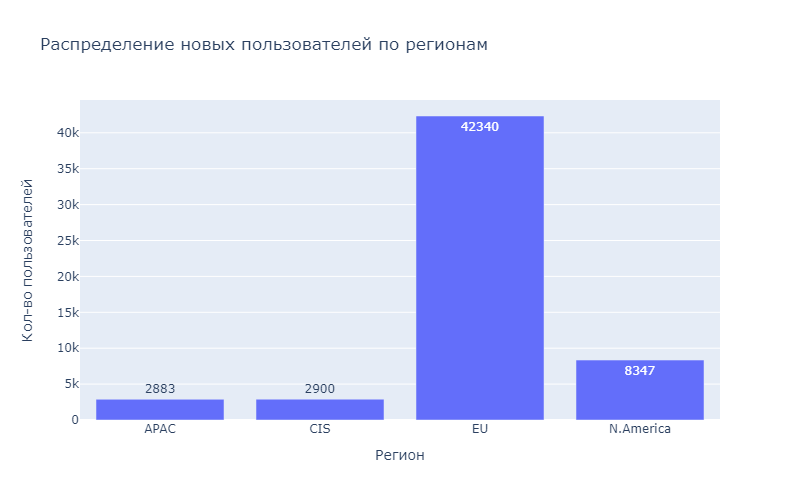

In [25]:
users_to_region = users.query('first_date <= "2020-12-21 23:59:59"')\
    .groupby('region')\
    .agg({'user_id': 'nunique'})\
    .reset_index()
display(users_to_region)
fig = px.bar(users_to_region, x='region', y="user_id",\
             text_auto='percent,%', width=800,height =500,\
             labels={
                     'region': 'Регион',
                     'user_id': 'Кол-во пользователей',
                 },
                title='Распределение новых пользователей по регионам')
fig.show()

* Пользователи из EU ~ 75 %.

Согласно ТЗ,в тест должно быть отобрано 15% новых пользователей из региона EU.
Проверим.

In [26]:
eu_users = users.query('first_date <= "2020-12-21 23:59:59" and region == "EU"')['user_id'].nunique()
our_test_users = participants_final['user_id'].nunique()
print (f'Доля отобранных новых пользователей из EU - {round(our_test_users / eu_users * 100,2)} %')

Доля отобранных новых пользователей из EU - 13.98 %


* Объединим поочередно таблицы для дальнейшего анализа, в т.ч. с учетом горизонта исследования

In [27]:
# сначала к participants_final присоединим таблицу users
participants_to_users = participants_final.merge(users, on = 'user_id')
display(participants_to_users.groupby('group')['user_id'].nunique())
participants_to_users.head()

group
A    3385
B    2533
Name: user_id, dtype: int64

,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone
2,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac
3,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone
4,482F14783456D21B,B,recommender_system_test,2020-12-14,EU,PC


Успешно, кол-во уникальных пользователей не изменилось, даты регистрации, именно в нашем тесте, как мы убедились ранее корректные.

In [28]:
events_final = participants_to_users.merge(events, on = 'user_id')
display(events_final.groupby('group')['user_id'].nunique())
events_final.head()

group
A    2422
B     822
Name: user_id, dtype: int64

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:56,purchase,4.99
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:57,product_cart,NaN
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,NaN


Видим большу потерю участников. Перед следующим шагом(установка лайфтайма), проанализируем потерянных пользователей. 

In [29]:
# выводим в отдельно данные по потерянным, сверяем цифры
check_losses = participants_to_users.query('user_id not in @events_final.user_id')
display(check_losses.groupby('group')['user_id'].nunique())
display(check_losses.groupby('region')['user_id'].nunique())
display(check_losses.groupby('first_date')['user_id'].nunique())
# присоединяем к ним events
check_losses = check_losses.merge(events, on='user_id')
check_losses

group
A     963
B    1711
Name: user_id, dtype: int64

region
APAC           27
CIS            25
EU           2518
N.America     104
Name: user_id, dtype: int64

first_date
2020-12-07    262
2020-12-08    190
2020-12-09     79
2020-12-10    256
2020-12-11    146
2020-12-12    331
2020-12-13    459
2020-12-14    181
2020-12-15    104
2020-12-16     16
2020-12-17     95
2020-12-18    108
2020-12-19    127
2020-12-20    134
2020-12-21    186
Name: user_id, dtype: int64

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details


**Итак, что мы видим:**
    
* при соединении было потеряно ~ 45 % пользователей - 2674,
* прицельно для группы В - 67,5 %, т.е. бОльшая часть потерянных относятся именно к ней ( 963/1711)
* бОльшая часть потерянных из EU (2518)
* регистрировались с 07.12.2020 по 21.12.2020, меньше всего 16.12.2020(16), больше всего 13.12.2020(459).

И, что самое важное, эти пользователи остались без событий. Т.е. мы можем предположить, что была проблема с логином именно из EU. Этот технический момент обязательно требует проверки. А те, кто в итоге "прорвался" в тест использовали VPN? Находились в другой стране?

In [30]:
# дополним финальную табличку корректным лайфтайом; разница - регистрацией/событие
events_final['difference'] = events_final['event_dt'] - events_final['first_date']

In [31]:
horizont = pd.Timedelta(days=14)

events_final = events_final[events_final['difference'] <= horizont]

Нам важен выделенный период, т.к. согласно ТЗ, мы ожилаем, что за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%. Т.е. оценивая воронку надо учитывать эти сроки.

**Шаг 2. Итоги.**

Отмечены нарушения с точки зрения ТЗ:

- дата остановки набора новых пользователей 2020-12-23, а в ТЗ указано, что 2020-12-21, однако, именно для нашего теста дата корректная - 2020-12-21.
- последнее событие теста - 2020-12-30 23:36:33, а согласно ТЗ тест должен был продолжаться до 2021-01-04;
- до остановки теста, в период с 25.12.2020 по 03.01.2021 в EU проводилась акция "Christmas&New Year Promo";
- параллельно с нашим тестом шел другой. В обоих тестах участвовали 1602 пользователя, из них в гр. В второго теста -"interface_eu_test" - 783 пользователя. Мы убедились, что участники из группы В второго теста распределены в нашем равномерно, однако, во избежании влияния отсекли их.
- кол-во пользователей в группах нашего теста существенно различается - 3385 - А, 2533 - В. 
- соответственно общее кол-во участников  меньше ожидаемого - 5918 ( ожидание - 6000),
- кол-во новых пользователей из EU 13,98% (по ТЗ - 15%); но стоит помнить, что участников второго теста из группы В мы отсекли.

*После формирования финальной таблицы(лайфтайм учтен) получились группы:*
A    2422
B     822

Что было отмечено по потерянным пользователям: 

- при соединении было потеряно ~ 45 % пользователей - 2674,
- рицельно для группы В - 67,5 %, т.е. бОльшая часть потерянных относятся именно к ней ( 963/1711),
- бОльшая часть потерянных из EU (2518),
- регистрировались с 07.12.2020 по 21.12.2020, меньше всего 16.12.2020(16), больше всего 13.12.2020(459).

И, что самое важное, эти пользователи остались без событий. Т.е. мы можем предположить, что была проблема с логином именно из EU. Этот технический момент обязательно требует проверки. А те, кто в итоге "прорвался" в тест использовали VPN? Находились в другой стране?

С учетом вышесказанного, пользователей из других регионов, оставшихся в тесте после обработки принято решение не отсекать.

#### Шаг 3. Исследовательский анализ данных.

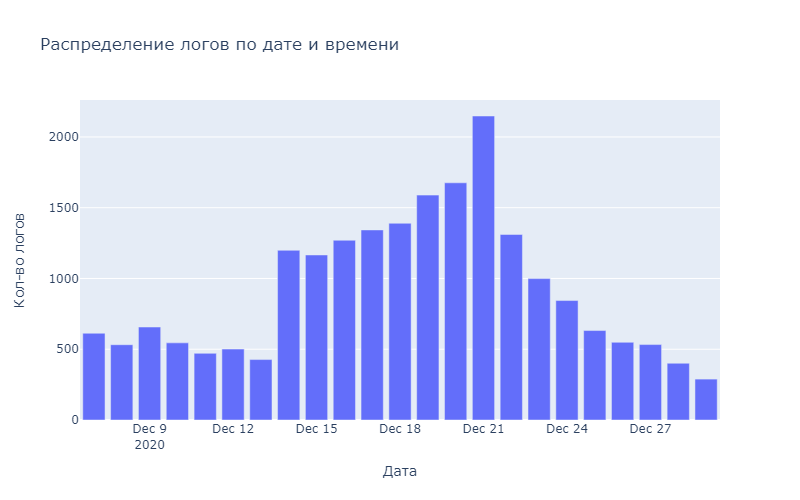

In [32]:
for_logs = events_final
for_logs['event_dt'] = pd.to_datetime(for_logs['event_dt']).dt.date
for_logs_total = for_logs.groupby('event_dt')\
    .agg({'user_id':'count'}) \
    .rename(columns={'user_id': 'count_logs'}) \
    .reset_index()

fig = px.bar(for_logs_total, x='event_dt', y="count_logs",\
             width=800,height =500,\
             labels={
                     'event_dt': 'Дата',
                     'count_logs': 'Кол-во логов',
                 },
                title='Распределение логов по дате и времени')
fig.show()

**Вывод:** видим подъем ~ с 14.12.2020, пик ~ на 21.12.2020 с постепенным снижение к 25.12.2020 - вероятно, это может быть связано с подготовкой к празднику- Рождеству.

,events_count
count,3244.000000
mean,6.499692
std,3.726504
min,1.000000
25%,4.000000
50%,6.000000
75%,9.000000
max,24.000000


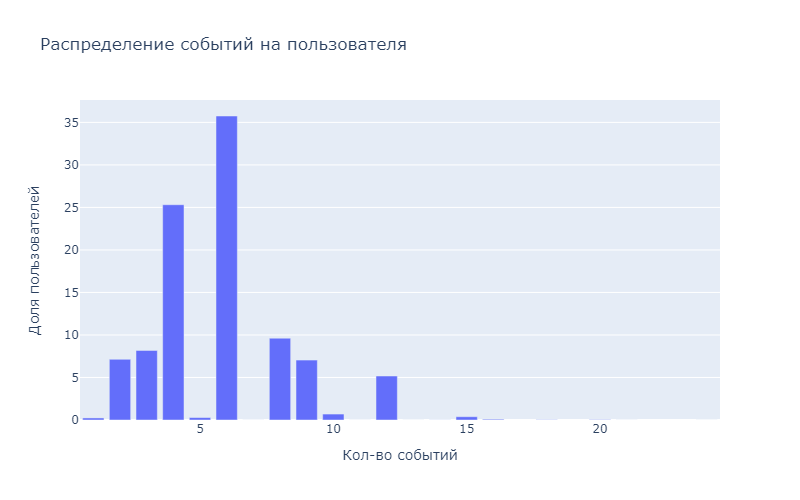

In [33]:
# посмотрим, сколько событий в среднем приходится на пользователя:
events_to_user = events_final.groupby('user_id').agg({'event_name': 'count'}) \
    .reset_index() \
    .rename(columns={'event_name':'events_count'})
display(events_to_user.describe())
events_to_user['total'] = events_to_user.groupby('events_count')['user_id'].transform('count')
events_to_user_bar = events_to_user.groupby('events_count').agg({'total':'sum'}) \
    .reset_index()
events_to_user_bar['percent'] = (events_to_user_bar['total'] /events_to_user_bar['total'].sum())*100

fig = px.bar(events_to_user_bar, x='events_count', y='percent',\
             width=800,height =500,\
             labels={
                     'events_count': 'Кол-во событий',
                     'percent': 'Доля пользователей',
                 },
                title='Распределение событий на пользователя')
fig.show()

**Вывод:** в среднем, на пользователя приходится ~ 6 событий. Минимум - 1, максимум - 24.

* Далее посмотрим, какие события есть в логах, как часто они встречаются? Отсортируем события по частоте.

,events_amount
event_name,
login,189552
product_page,125563
purchase,62740
product_cart,62462


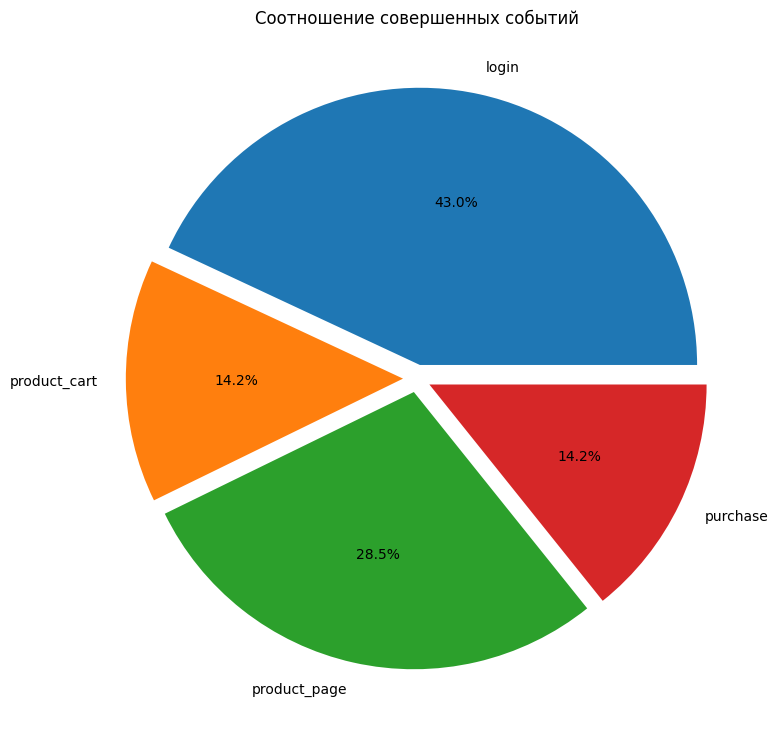

In [34]:
event_diff = events.groupby('event_name') \
.agg({'user_id': 'count'}) \
.rename(columns={'user_id': 'events_amount'})

display(event_diff.sort_values(by='events_amount',ascending=False))

explode = (0.05, 0.05, 0.05, 0.05)
fig1, ax1 = plt.subplots(figsize=(12,9))
ax1.pie(event_diff['events_amount'],labels = event_diff.index,autopct='%1.1f%%', explode=explode)
ax1.set_title('Соотношение совершенных событий');

**В нашем распоряжении 4 вида событий, распределенных по частоте следующим образом:**
- login - авторизация - 9545 (45,3 %)
- product_page - просмотр карточек товаров - 5898 (28 %)
- purchase - покупка - 2848 (13,5 %)
- product_cart - просмотр корзины - 2794 (13,3 %)

* Посчитаем частоту совершения имеющихся в нашем распоряжении событий

,event_name,users_count,percent
0,login,58697,99.99
1,product_page,38929,66.32
2,purchase,19569,33.34
3,product_cart,19284,32.85


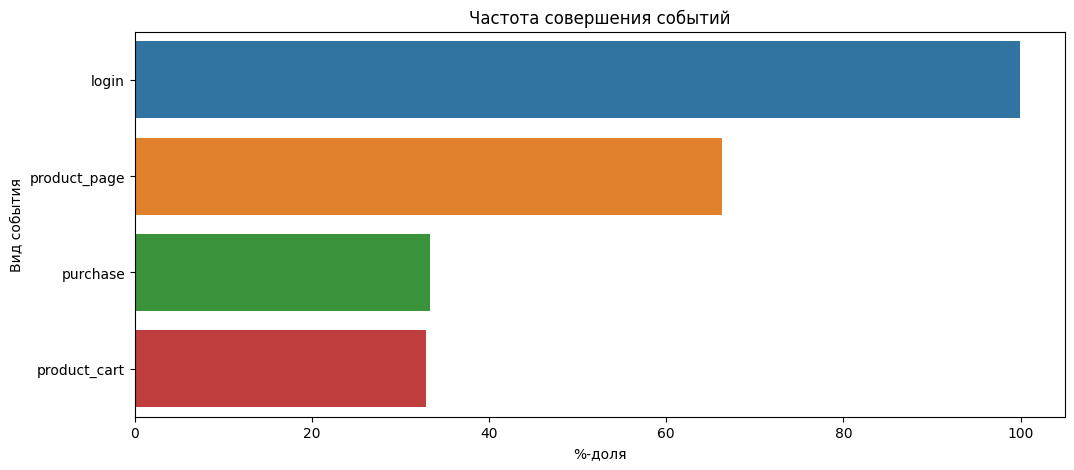

In [35]:
event_type_to_user = events.groupby('event_name').agg({'user_id': 'nunique'}) \
    .rename(columns={'user_id' : 'users_count'})\
    .sort_values(by='users_count', ascending=False)\
    .reset_index()
event_type_to_user['percent'] = event_type_to_user['users_count'] / events['user_id'].nunique() * 100
display(event_type_to_user.round(2))


plt.figure(figsize=(12, 5))
ax = sns.barplot(x='percent', y='event_name', data=event_type_to_user)
ax.set(xlabel='%-доля',
       ylabel='Вид события',
       title='Частота совершения событий')
plt.show()

Обращает на себя внимание порядок событий. Т.е. мы видим, что доля тех, кто совершил покупку чуть больше тех,кто перешел в корзину. Для дальнейшего исследования нам необходим корректный порядок. По алфавиту сортирование не будет верным, можно создать доп.числовой столбец. 

In [36]:
event_type_to_user['right_order'] = [1, 2, 4, 3]
event_type_to_user = event_type_to_user.sort_values(by='right_order')
event_type_to_user = event_type_to_user.reset_index(drop=True)
event_type_to_user

,event_name,users_count,percent,right_order
0,login,58697,99.989779,1
1,product_page,38929,66.315180,2
2,product_cart,19284,32.850110,3
3,purchase,19569,33.335605,4


* Построим воронку событий 

,event_name,users_count,percent,right_order
0,login,58697,99.989779,1
1,product_page,38929,66.315180,2
2,product_cart,19284,32.850110,3
3,purchase,19569,33.335605,4


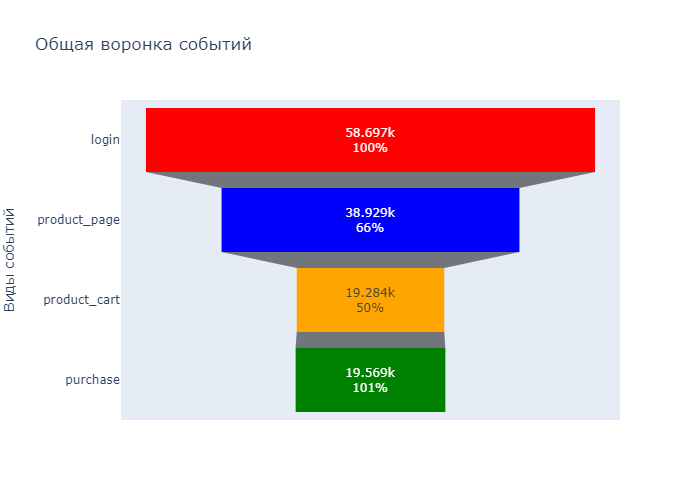

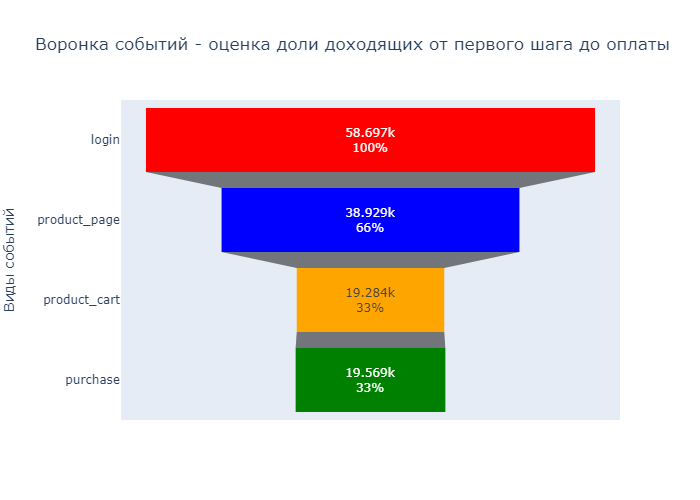

In [37]:
display(event_type_to_user)

fig = go.Figure(go.Funnel(y = event_type_to_user['event_name'],
    x = event_type_to_user['users_count'],
    textposition = "inside",
    textinfo = "value+percent previous",
    marker = {"color": ["red", "blue", "orange", "green"]}))
fig.update_layout(title_text='Общая воронка событий',
                 yaxis_title = 'Виды событий')
fig.show()


fig = go.Figure(go.Funnel(y = event_type_to_user['event_name'],
    x = event_type_to_user['users_count'],
    textposition = "inside",
    textinfo = "value+percent initial",
    marker = {"color": ["red", "blue", "orange", "green"]}))
fig.update_layout(title_text='Воронка событий - оценка доли доходящих от первого шага до оплаты',
                 yaxis_title = 'Виды событий')
fig.show()

**Вывод:**
- наибольшее количество пользователей теряется после первого события (~37%), если дело "дошло до корзины", то к оплате переходят более 100 % польвателей? Такого быть не может, вероятно, есть возможность оплаты без перехода в корзину("по клику", со страницы карточки товара, например).

- только 31% от первоначального количества пользователей успешно оплачивают товары, добавленные в корзину.

* Посмотрим, на различия по группам нашего теста - распеределение логов, пользователей

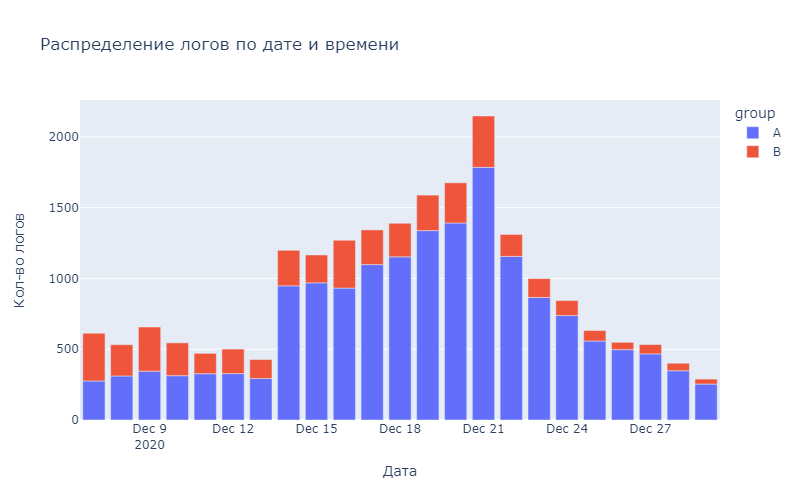

In [38]:
for_logs_by_group= for_logs.groupby(['group','event_dt'])\
    .agg({'user_id':'count'}) \
    .rename(columns={'user_id': 'count_logs'}) \
    .reset_index()

fig = px.bar(for_logs_by_group, x='event_dt', y="count_logs",\
             color='group',width=800,height =500,\
             labels={
                     'event_dt': 'Дата',
                     'count_logs': 'Кол-во логов',
                 },
                title='Распределение логов по дате и времени')
fig.show()

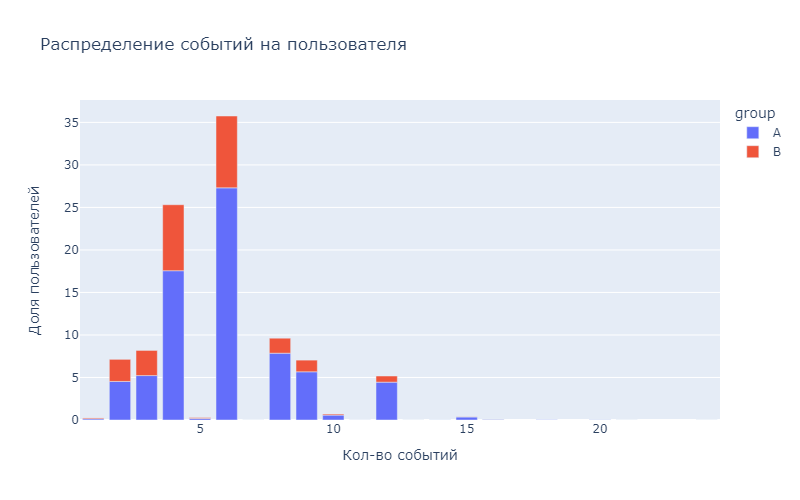

In [39]:
events_users_by_groups = events_final.groupby(['user_id','group']).agg({'event_name': 'count'}) \
    .reset_index() \
    .rename(columns={'event_name':'events_count'})

events_users_by_groups['total'] = events_users_by_groups.groupby('events_count')['user_id'].transform('count')

events_users_by_groups_bar = events_users_by_groups.groupby(['group','events_count']).agg({'total':'sum'}) \
  .reset_index()

events_users_by_groups_bar['percent'] = (events_users_by_groups_bar['total'] /events_users_by_groups_bar['total'].sum())*100


fig = px.bar(events_users_by_groups_bar, x='events_count', y='percent',\
             color='group',width=800,height =500,\
             labels={
                     'events_count': 'Кол-во событий',
                     'percent': 'Доля пользователей',
                 },
                title='Распределение событий на пользователя')
fig.show()

* Ожидаемо, видим, что активность группы В ниже. 

In [40]:
#  объединим разбивку по событиям в гр. А и В в одну табличку, зададим верный порядок

both_groups = events_final.groupby(['event_name', 'group']) \
    .agg({'user_id': 'nunique'}) \
    .reset_index() \
    .rename(columns={'user_id' : 'users_count'})\
    .sort_values(by=['group','users_count'], ascending=False)
both_groups['right_order'] = [1, 2, 4, 3, 5, 6, 8, 7]
both_groups = both_groups.sort_values(by='right_order')
both_groups = both_groups.reset_index(drop=True)

A_max = both_groups[both_groups['group'] == 'A']['users_count'].max()
B_max = both_groups[both_groups['group'] == 'B']['users_count'].max()

both_groups['different_previous'] = both_groups['users_count'] / both_groups.groupby('group')['users_count'].shift(1) * 100
both_groups['different_previous'] = round(both_groups['different_previous'].fillna(100),2)

both_groups['different_initial'] = both_groups.apply(
    lambda row: row['users_count'] / B_max * 100 if row['group'] == 'B' else row['users_count'] / A_max * 100,
    axis=1
)

both_groups['different_initial'] = round(both_groups['different_initial'],2)
both_groups

,event_name,group,users_count,right_order,different_previous,different_initial
0,login,B,821,1,100.00,100.00
1,product_page,B,459,2,55.91,55.91
2,product_cart,B,225,3,49.02,27.41
3,purchase,B,226,4,100.44,27.53
4,login,A,2422,5,100.00,100.00
5,product_page,A,1571,6,64.86,64.86
6,product_cart,A,728,7,46.34,30.06
7,purchase,A,773,8,106.18,31.92


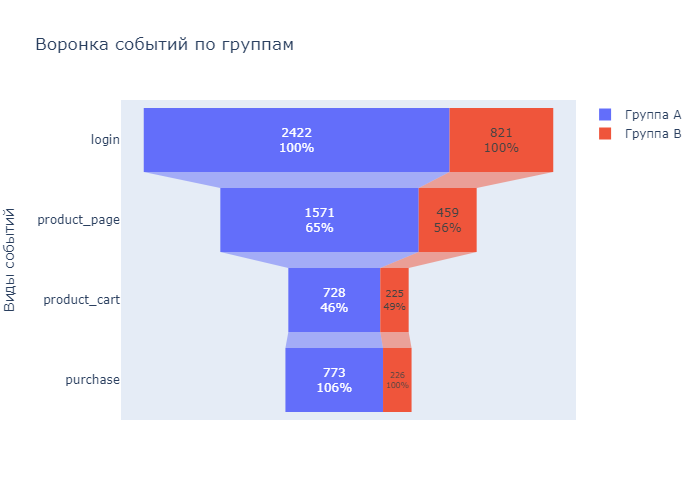

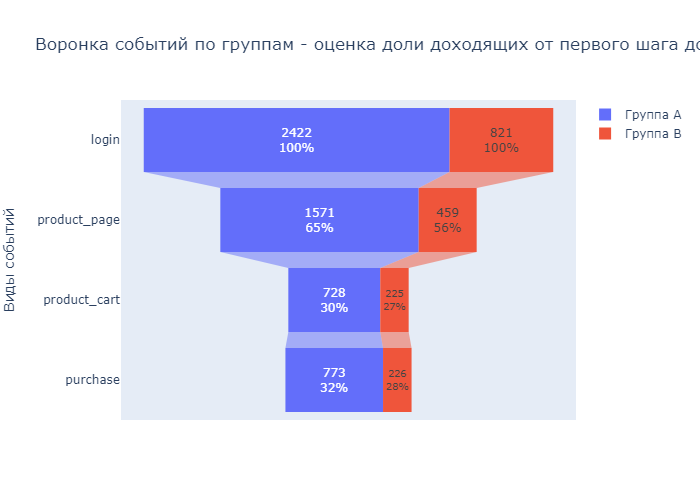

In [41]:
fig = go.Figure()

fig.add_trace(go.Funnel(name = 'Группа А',
                        y = both_groups.query('group == "A"')['event_name'],
                        x = both_groups.query('group == "A"')['users_count'],
                        textposition = 'inside',
                        textinfo = 'value + percent previous'))

fig.add_trace(go.Funnel(name = 'Группа В',
                        y = both_groups.query('group == "B"')['event_name'],
                        x = both_groups.query('group == "B"')['users_count'],
                        textposition = 'inside',
                        textinfo = 'value + percent previous'))
                        
fig.update_layout(title_text='Воронка событий по группам',
                 yaxis_title = 'Виды событий')
fig.show()

fig = go.Figure()

fig.add_trace(go.Funnel(name = 'Группа А',
                        y = both_groups.query('group == "A"')['event_name'],
                        x = both_groups.query('group == "A"')['users_count'],
                        textposition = 'inside',
                        textinfo = 'value + percent initial'))

fig.add_trace(go.Funnel(name = 'Группа В',
                        y = both_groups.query('group == "B"')['event_name'],
                        x = both_groups.query('group == "B"')['users_count'],
                        textposition = 'inside',
                        textinfo = 'value + percent initial'))
                        
fig.update_layout(title_text='Воронка событий по группам - оценка доли доходящих от первого шага до оплаты',
                 yaxis_title = 'Виды событий')
fig.show()

**Вывод:**

В разбивке по группам картина аналогична -  наибольшее количество пользователей теряется после первого шага:
- ~ 35 % - гр. А,
- ~ 44 % - гр. В.

Что касается целевого увеличения метрики в 10 % группе В не удалось его достигнуть. Группа В уступает группе А. Распределение % (повышение при переходе к оплате), вероятно, как ранее отмечалось, связано с возможностью оплаты без перехода в корзину. 

**Шаг 3. Итоги.**

- по логам видим подъем ~ с 14.12.2020, пик ~ на 21.12.2020 с постепенным снижение к 25.12.2020 - вероятно, это может быть связано с подготовкой к празднику- Рождеству;

- в среднем, на пользователя приходится ~ 6 событий. Минимум - 1, максимум - 24;

- в нашем распоряжении 4 вида событий, распределенных по частоте следующим образом:**

*login - авторизация - 9545 (45,3 %)
*product_page - просмотр карточек товаров - 5898 (28 %)
*purchase - покупка - 2848 (13,5 %)
*product_cart - просмотр корзины - 2794 (13,3 %);


- обращает на себя внимание порядок событий. Т.е. мы видим, что доля тех, кто совершил покупку чуть больше тех,кто перешел в корзину. Наибольшее количество пользователей теряется после первого события (~37%), если дело "дошло до корзины", то к оплате переходят более 100 % польвателей? Такого быть не может, вероятно, есть возможность оплаты без перехода в корзину("по клику", со страницы карточки товара, например);

- только 31% от первоначального количества пользователей успешно оплачивают товары, добавленные в корзину;

- ожидаемо, видим, что кол-во событий на пользователя в группе В ниже;

- в разбивке по группам картина аналогична -  наибольшее количество пользователей теряется после первого шага:

~ 35 % - гр. А,
~ 44 % - гр. В.
Вновь видим, что пользователи, вероятно, используют возможность оплаты без перехода в корзину.

#### Шаг 4. Оценка результатов A/B-тестирования,проверка гипотез.

Cогласно ТЗ, нам необходимо сопоставить доли уникальных пользователей - проверить три гипотезы о равенстве долей в группах А и В при конверсии в:

* просмотр карточек товаров — событие product_page,
* просмотры корзины — product_cart,
* покупки — purchase.

В нашем распоряжении 3 вида событий,  для всех тестов мы введем поправку Бонферрони bonferroni_alpha = alpha / 3, во избежании получения ложных результатов.

Для каждого сравнения введем нулевую и альтернативную гипотезу:


**Нулевая гипотеза:** доли уникальных пользователей, побывавших на этапе воронки одинаковы.


**Альтернативная гипотеза:** доли уникальных пользователей, побывавших на этапе отличаются.


In [42]:
# Выделем участников групп в отдельные переменные
A_group = events_final[events_final['group'] == 'A']
B_group = events_final[events_final['group'] == 'B']

In [43]:
#  Так как нам потребуются аналогичные расчеты - создадим функцию

def tests (A_group, B_group, event_type, alpha, n):

 # критический уровень статистической значимости c поправкой Бонферрони
    alpha_with_bonferroni = alpha / n
 
    # число пользователей в группе 1 и группе 2:
    num_of_users = np.array([A_group['user_id'].nunique(), 
                        B_group['user_id'].nunique()])

    # число пользователей, совершивших событие в группе 1 и группе 2
    success = np.array([A_group[A_group['event_name'] == event_type]['user_id'].nunique(), 
                        B_group[B_group['event_name'] == event_type]['user_id'].nunique()])

    # пропорции успехов в группах:
    p1 = success[0]/num_of_users[0]
    p2 = success[1]/num_of_users[1]
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (success[0] + success[1]) / (num_of_users[0] + num_of_users[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/num_of_users[0] + 1/num_of_users[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2   #тест двусторонний, удваиваем результат
    
    print('Событие:', event_type)
    print('p-значение: ', p_value)

    if p_value < alpha_with_bonferroni:
        print('Отвергаем нулевую гипотезу - между долями есть разница')
    else:
        print(
        'Не удалось отвергнуть нулевую гипотезу')

In [44]:
# согласно ТЗ нас интересуют 3 события, поэтому выд-м именно их
for event_type in ['product_page', 'product_cart', 'purchase']: 
    tests(A_group, B_group, event_type,0.05, 3)
    print()

Событие: product_page
p-значение:  3.8415005565450855e-06
Отвергаем нулевую гипотезу - между долями есть разница

Событие: product_cart
p-значение:  0.14412076974264498
Не удалось отвергнуть нулевую гипотезу

Событие: purchase
p-значение:  0.01764968717521609
Не удалось отвергнуть нулевую гипотезу



#### Шаг 5. Общие выводы и заключение. 

Отмечены нарушения с точки зрения ТЗ:

- дата остановки набора новых пользователей 2020-12-23, а в ТЗ указано, что 2020-12-21, однако, именно для нашего теста дата корректная - 2020-12-21.
- последнее событие теста - 2020-12-30 23:36:33, а согласно ТЗ тест должен был продолжаться до 2021-01-04;
- до остановки теста, в период с 25.12.2020 по 03.01.2021 в EU проводилась акция "Christmas&New Year Promo";
- параллельно с нашим тестом шел другой. В обоих тестах участвовали 1602 пользователя, из них в гр. В второго теста -"interface_eu_test" - 783 пользователя. Мы убедились, что участники из группы В второго теста распределены в нашем равномерно, однако, во избежании влияния отсекли их.
- кол-во пользователей в группах нашего теста существенно различается - 3385 - А, 2533 - В. 
- соответственно общее кол-во участников  меньше ожидаемого - 5918 ( ожидание - 6000),
- кол-во новых пользователей из EU 13,98% (по ТЗ - 15%); но стоит помнить, что участников второго теста из группы В мы отсекли.

*После формирования финальной таблицы(лайфтайм учтен) получились группы:*
A    2422
B     822

Что было отмечено по потерянным пользователям: 

- при соединении было потеряно ~ 45 % пользователей - 2674,
- рицельно для группы В - 67,5 %, т.е. бОльшая часть потерянных относятся именно к ней ( 963/1711),
- бОльшая часть потерянных из EU (2518),
- регистрировались с 07.12.2020 по 21.12.2020, меньше всего 16.12.2020(16), больше всего 13.12.2020(459).

И, что самое важное, эти пользователи остались без событий. Т.е. мы можем предположить, что была проблема с логином именно из EU. Этот технический момент обязательно требует проверки. А те, кто в итоге "прорвался" в тест использовали VPN? Находились в другой стране?

С учетом вышесказанного, пользователей из других регионов, оставшихся в тесте после обработки принято решение не отсекать.

В/у нарушения/факторы могли серьезно повлиять на тест. В первую очередь, следует корректно выбирать время теста, чтобы оно не совпадало с проведением иных акций; убедиться в корректной работе технически, отсуствии ошибок во время теста.

В ходе исследования была отмечена особенность - события имели неожиданную последовательность, покупка могла предшествовать попаданию в корзину. Предполагается, возможность быстрой оплаты. Такое стоит учитывать при проведении последующих тестов/сборе данных. 

По результатам проверки гипотез о равенстве долей уникальных пользователей:

* доли уникальных пользователей, побывавших на этапе воронки “просмотр карточек товаров” - , отличаются. *Потери после авторизации - ~ 35 % - гр. А, ~ 44 % - гр. В.

* разница в долях уникальных пользователей между группами А и В при конверсии в “просмотр корзины” и в “покупку” .


Общее заключение  - по результатам анализа представленных данных внедрение улучшенной рекомендательной системы **не дало ожидаемого эффекта.**